In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re, os

In [2]:
def compute_wer_loss(data):
    out = {}
    name=None
    for line in data:
        if ("EVAL MODEL" in line):
            iter_number = re.search(r'(\d)\_iter', line)
            iter_number = iter_number.group(1) if iter_number is not None else '1'
            name=line.strip().split(' ')[-2].split('/')[-1]
            name = iter_number + '_iter_' + name.replace('checkpoint-','') 
            # print(name)
            # print(line)
            out[name]={}
        elif name in out:
            dataset = re.search(r'DATASET: ([a-zA-Z_]+)', line)
            wer = re.search(r'WER: ([\d.]+)', line)
            loss = re.search(r'LOSS: ([\d.]+)', line)
            cal_wer = re.search(r'CALLSIGN WER: ([\d.]+)', line)
            if dataset is None or wer is None and loss is None:
                continue
            out[name][dataset.group(1)]={
                'wer': float(wer.group(1) if wer is not None else 0.0),
                'loss': float(loss.group(1) if loss is not None else 0.0),
            }    
            if cal_wer is not None:
                out[name][dataset.group(1)].update({'cal_wer': float(cal_wer.group(1))})
    return out

In [3]:
def compute_total_wer(out, num_examples):
    # total wer
    checkpoints =[]
    wer = {'total':[]}
    cal_wer = {'total':[]}
    loss = {'total':[]}
    for checkpoint,ds_set in out.items():
        checkpoints.append(checkpoint)
        total_wer = 0
        total_loss = 0
        total_cal_wer = 0
        for ds_name,wer_loss in ds_set.items():
            if ds_name not in num_examples.keys():
                continue
            if ds_name not in wer:
                wer[ds_name] = []
            if ds_name not in loss:
                loss[ds_name] = []
            if ds_name not in cal_wer:
                cal_wer[ds_name] = []
            wer[ds_name].append(wer_loss['wer'])
            loss[ds_name].append(wer_loss['loss'])
            if 'cal_wer' in wer_loss:
                cal_wer[ds_name].append(wer_loss['cal_wer'])
                total_cal_wer += wer_loss['cal_wer'] * num_examples[ds_name]
            total_wer += wer_loss['wer'] * num_examples[ds_name]
            total_loss += wer_loss['loss'] * num_examples[ds_name]
        # average wer and loss
        wer['total'].append(total_wer / sum(num_examples.values()))
        loss['total'].append(total_loss / sum(num_examples.values()))
        if 'cal_wer' in wer_loss:
            cal_wer['total'].append(total_cal_wer / sum(num_examples.values()))
    return checkpoints, wer, loss, cal_wer

In [4]:
def plot_wer_loss(wer,loss, cal_wer, checkpoints,src_file):
    _,ax = plt.subplots(3,1,figsize=(10,8))
    # plot WER
    best={}
    for ds_name in wer:
        best[ds_name] = wer[ds_name][np.argmin(wer['total'])]  
        if ds_name == 'total':
            ax[0].plot(checkpoints,wer['total'],linewidth=4, marker='',color='orange', label='Total WER', zorder=10)
            continue
        ax[0].plot(checkpoints,wer[ds_name],linestyle='--', marker='o',alpha=0.6, label=ds_name)
    ax[0].set_xlabel('Checkpoint')
    ax[0].tick_params(axis='x', rotation=45)
    # ax[0].set_xticks([0,14,29,44])
    ax[0].set_ylabel('WER')
    ax[0].set_title('Word Error Rate')
    ax[0].legend()
    ax[0].grid(True)
    # ax[0].set_ylim(0, 100)

    # plot loss
    for ds_name in loss:
        if ds_name == 'total':
            ax[1].plot(checkpoints,loss['total'],linewidth=4, marker='o', label='Total Loss', zorder=10)
            continue
        ax[1].plot(checkpoints,loss[ds_name],linestyle='--', marker='o',alpha=0.6, label=ds_name)

    ax[1].set_xlabel('Checkpoint')
    ax[1].set_ylabel('Loss')
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].set_title('Loss')
    ax[1].legend()
    ax[1].grid(True)
    
    # plot callsign wer if set
    if (cal_wer is not []):
        # plot loss
        for ds_name in loss:
            if ds_name == 'total':
                ax[2].plot(checkpoints,cal_wer['total'],linewidth=4, marker='o', label='Total WER', zorder=10)
                continue
            ax[2].plot(checkpoints,cal_wer[ds_name],linestyle='--', marker='o',alpha=0.6, label=ds_name)

        ax[2].set_xlabel('Checkpoint')
        ax[2].set_ylabel('WER')
        ax[2].tick_params(axis='x', rotation=45)
        ax[2].set_title('Callsign WER')
        ax[2].legend()
        ax[2].grid(True)
        
    plt.tight_layout()
    
    
    
    # if SAVE:
    plt.savefig(os.path.dirname(src_file) + '/' + os.path.basename(src_file).split('.')[0] + '.png', dpi=300)

    print (f"Best WER - {checkpoints[np.argmin(wer['total'])]}:")
    with open(os.path.dirname(src_file) + '/' + os.path.basename(src_file).split('.')[0] + '.best', 'w') as f:
        f.write(f"Best WER - epoch {np.argmin(wer['total'])+1}, {checkpoints[np.argmin(wer['total'])]}:\n")
        for ds_name in best:
            print (ds_name, best[ds_name])
            # to file
            f.write(f"{ds_name} {best[ds_name]}\n")

************************************************************************************
shortts/vanmed-allds/mp_eval.txt
************************************************************************************
Best WER - 1_iter_2538:
total 35.43837338645098
atco_en_ruzyne 31.654676258992804
atco_en_stefanik 31.574074074074076
atco_en_zurich 36.57834101382488
************************************************************************************
shortts/vanmed-allds/vp_eval.txt
************************************************************************************
Best WER - 1_iter_5915:
total 34.17406256742313
atco_en_ruzyne 30.755395683453234
atco_en_stefanik 30.0
atco_en_zurich 35.29185867895545


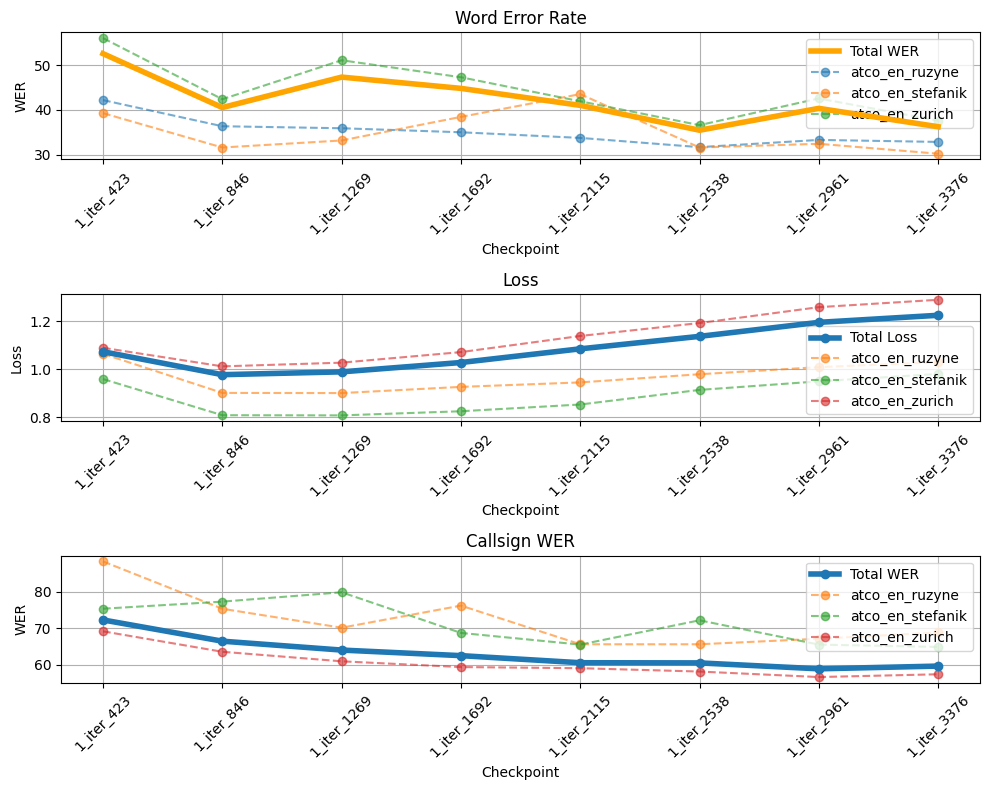

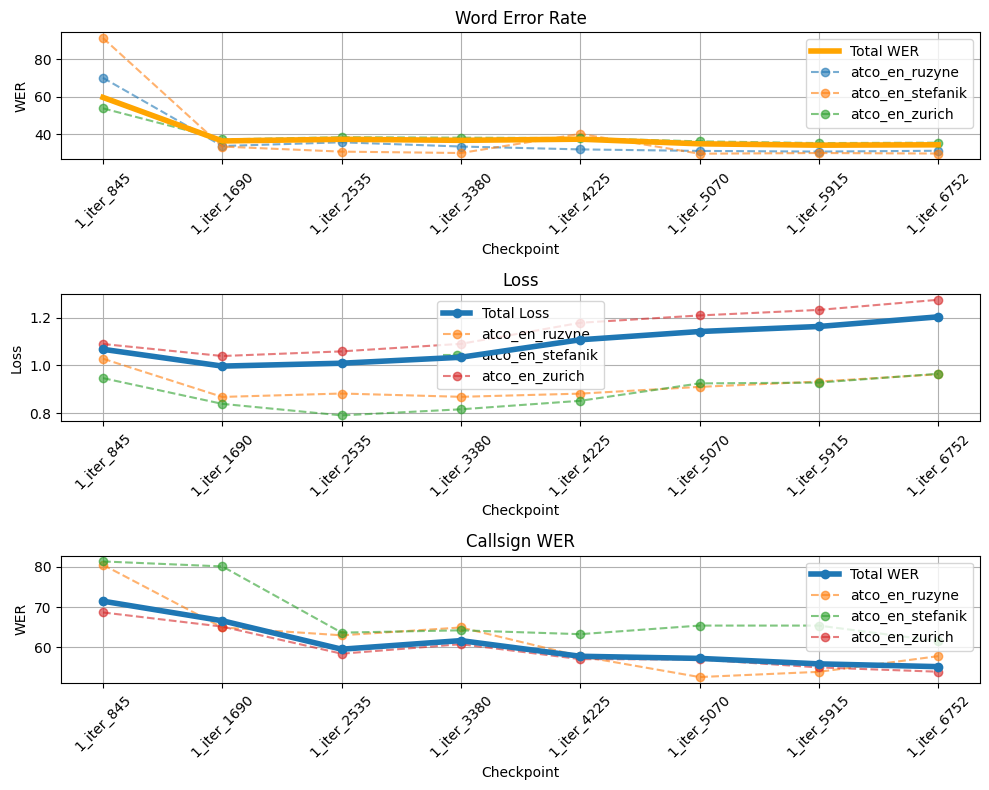

In [8]:
files = [    
    # ===========================================
    # BASE SHORTTS+FULLTS
    # ===========================================
    # "fullts/vanmed-allds/mp_eval.txt",
    # "fullts/vanmed-allds/vp_eval.txt",
    "shortts/vanmed-allds/mp_eval.txt",
    "shortts/vanmed-allds/vp_eval.txt"
    # ===========================================
    # PROMPT FULLTS
    # ===========================================
    # "prompt/fullts/allds_lr1/5B_eval.txt",
    # "prompt/fullts/allds_lr1/50B_eval.txt",
    # "prompt/fullts/allds_lr1/AG_eval.txt",
    # "prompt/fullts/allds_lr1/AG4B_eval.txt"
]
# SAVE=False

for file in files:
    print('************************************************************************************')
    print(file)
    print('************************************************************************************')
    data = open(file,'r').readlines()

    # number of examples in dataset
    num_examples = {
        'atco_en_ruzyne': 70,
        'atco_en_stefanik': 53,
        'atco_en_zurich': 412,
        # 'atco_fr': 33,
        # 'atco_other_lang': 40,
        # 'hiwire_fr': 800,
        # 'hiwire_gr': 400,
        # 'hiwire_sp': 300,
        # 'malorca': 1557,
        # 'nato': 492
    }

    import json
    out=compute_wer_loss(data)
    # print(json.dumps(out, indent=2))
    checkpoints, wer, loss, cal_wer = compute_total_wer(out, num_examples)
    plot_wer_loss(wer,loss, cal_wer, checkpoints, file)

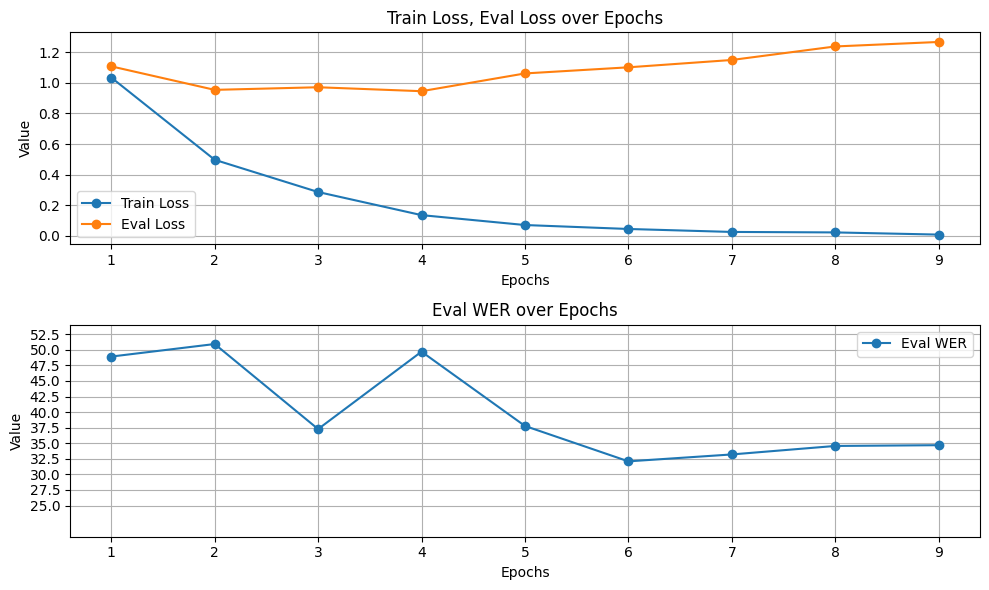

In [ ]:
# Data for the graph
epochs = [1, 2, 3, 4, 5, 6, 7, 8,9]
train_loss = [1.034900, 0.497400, 0.286800, 0.135800, 0.071100, 0.045300, 0.025900,0.022800,0.008600]
eval_loss = [1.108031, 0.954353, 0.971437, 0.945680, 1.061698, 1.101715, 1.149648,1.238018,1.267378]
eval_wer = [48.908584, 50.919087, 37.272280, 49.696373, 37.772854, 32.094206, 33.202035,34.564254,34.687346]

# Plotting the graph
fig,ax=plt.subplots(2,1,figsize=(10, 6))
ax[0].plot(epochs, train_loss, marker='o', label='Train Loss')
ax[0].plot(epochs, eval_loss, marker='o', label='Eval Loss')

# Adding labels, title, and legend
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Value')
ax[0].set_title('Train Loss, Eval Loss over Epochs')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(epochs, eval_wer, marker='o', label='Eval WER')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Value')
ax[1].set_title('Eval WER over Epochs')
ax[1].legend()
ax[1].grid(True)
ax[1].set_ylim(20, 54)
ax[1].set_yticks(np.arange(25, 55, 2.5))

plt.tight_layout()

# Display the graph
# plt.show()
if SAVE:
    plt.savefig('../evaluation/TEST/NEWatco-atco-nop_loss_wer.png', dpi=300)